# Индивидуальное задание (регрессия)
Группа 45/2
Вариант 7
---

## Предсказание загрязнения воздуха
Датасет BeijingPM20100101_20151231.csv содержит данные о загрязнении воздуха в Пекине (Китай) с 1 января 2010 года по 31 декабря 2015 года. Данные были собраны с
помощью нескольких пунктов контроля качества воздуха, размещенных по всему городу. Каждая запись в датасете содержит информацию о качестве воздуха на конкретную
дату и время.


**Данные**
В датасете представлены следующие признаки:
No: Номер строки
year: Год 
month: Месяц 
day: День 
hour: Час 
season: Сезон 
PM: Концентрация PM2.5 (мкг/м3) 
DEWP: Точка росы (градусы Цельсия)
TEMP: Температура (градусы Цельсия)
HUMI: Влажность (%)
PRES: Давление (гПа)
cbwd: Сочетанное направление ветра
Iws: Накопленная скорость ветра (м/с)
precipitation: Часовые осадки (мм)
Iprec: Накопленные осадки (мм)

**Импорт библиотек**

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 

**Задание 1.** 
Загрузка датасета.

In [162]:
file_path = 'BeijingPM20100101_20151231.csv'
beijing_pm_data = pd.read_csv(file_path)

**Задание 2.** 
Изучение размерности датасета и типов переменных.

In [163]:
# Проверка размерности датасета и типов переменных
data_shape = beijing_pm_data.shape
data_types = beijing_pm_data.dtypes

Размерность датасета: 52584 строки и 18 столбцов.

In [164]:
data_shape

(52584, 18)

In [165]:
data_types

No                   int64
year                 int64
month                int64
day                  int64
hour                 int64
season               int64
PM_Dongsi          float64
PM_Dongsihuan      float64
PM_Nongzhanguan    float64
PM_US Post         float64
DEWP               float64
HUMI               float64
PRES               float64
TEMP               float64
cbwd                object
Iws                float64
precipitation      float64
Iprec              float64
dtype: object

**Задание 3.** 
Проверка наличия пропущенных значений и принятие решения о их обработке (заполнение или удаление пропущенных значений).

In [166]:
missing_values = beijing_pm_data.isnull().sum()

missing_values_summary = missing_values[missing_values > 0]
missing_values_summary

PM_Dongsi          27532
PM_Dongsihuan      32076
PM_Nongzhanguan    27653
PM_US Post          2197
DEWP                   5
HUMI                 339
PRES                 339
TEMP                   5
cbwd                   5
Iws                    5
precipitation        484
Iprec                484
dtype: int64

Определение стратегии заполнения для каждого столбца
Для числовых столбцов использую медиану, для категориальных - моду

In [167]:
# Медиана для числовых столбцов
numerical_columns = beijing_pm_data.select_dtypes(include=['float64', 'int64']).columns
numerical_medians = beijing_pm_data[numerical_columns].median()

# Мода для категориальных столбцов
categorical_columns = beijing_pm_data.select_dtypes(include=['object']).columns
categorical_modes = beijing_pm_data[categorical_columns].mode().iloc[0]

# Создание словаря со стратегиями заполнения для каждого столбца
fill_values = {**numerical_medians.to_dict(), **categorical_modes.to_dict()}

# Заполнение пропущенных значений
beijing_pm_data_filled = beijing_pm_data.fillna(fill_values)

Проверка наличия пропущенных значений после заполнения.

In [168]:
# Проверка наличия пропущенных значений после заполнения
missing_values_after_filling = beijing_pm_data_filled.isnull().sum()
missing_values_after_filling_summary = missing_values_after_filling[missing_values_after_filling > 0]

missing_values_after_filling_summary

Series([], dtype: int64)

**Задание 4.** 
Анализ распределения переменных с помощью описательной статистики (среднее, медиана, стандартное отклонение).

In [169]:
# Вычисление описательной статистики без учета категориального столбца 'cbwd'
numerical_data = beijing_pm_data_filled.drop(columns=['cbwd'])
descriptive_statistics_excluding_cbwd = numerical_data.describe()

# Добавление медианы в описательную статистику с использованием метода concat
medians_excluding_cbwd = numerical_data.median().to_frame().T
descriptive_statistics_with_median = pd.concat([descriptive_statistics_excluding_cbwd, medians_excluding_cbwd])

# Вывод описательной статистики
descriptive_statistics_with_median

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
count,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000
mean,26292.500000,2012.499772,6.523962,15.726609,11.500000,2.491100,75.984045,77.578826,74.632265,94.780161,2.074547,54.604984,1016.462441,12.587175,23.260085,19.081420,19.339348
std,15179.837614,1.707485,3.448452,8.798896,6.922252,1.116988,61.511272,56.262788,62.063879,89.870210,14.221382,25.907440,10.261898,12.097959,49.279687,4360.826697,4360.827213
min,1.000000,2010.000000,1.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,1.000000,-40.000000,2.000000,991.000000,-19.000000,0.450000,0.000000,0.000000
25%,13146.750000,2011.000000,4.000000,8.000000,5.750000,1.000000,64.000000,68.000000,62.000000,29.000000,-10.000000,32.000000,1008.000000,2.000000,1.790000,0.000000,0.000000
50%,26292.500000,2012.000000,7.000000,16.000000,11.500000,2.000000,64.000000,68.000000,62.000000,69.000000,2.000000,55.000000,1016.000000,14.000000,4.920000,0.000000,0.000000
75%,39438.250000,2014.000000,10.000000,23.000000,17.250000,3.000000,64.000000,68.000000,62.000000,128.000000,15.000000,78.000000,1025.000000,23.000000,21.020000,0.000000,0.000000
max,52584.000000,2015.000000,12.000000,31.000000,23.000000,4.000000,737.000000,672.000000,844.000000,994.000000,28.000000,100.000000,1046.000000,42.000000,585.600000,999990.000000,999990.000000
0,26292.500000,2012.000000,7.000000,16.000000,11.500000,2.000000,64.000000,68.000000,62.000000,69.000000,2.000000,55.000000,1016.000000,14.000000,4.920000,0.000000,0.000000


**Задание 5.**
Исследование корреляционной матрицы между всеми переменными для выявления возможных зависимостей.

In [170]:
# Вычисление корреляционной матрицы, исключая категориальный столбец 'cbwd'
correlation_matrix_excluding_cbwd = numerical_data.corr()

correlation_matrix_excluding_cbwd

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
No,1.000000,9.860132e-01,1.662567e-01,1.550485e-02,4.560162e-04,3.482495e-02,0.158852,0.134346,0.171238,-0.042784,0.068508,0.018888,-0.015020,0.073933,-0.062121,0.007177,0.007165
year,0.986013,1.000000e+00,1.753370e-04,-2.016196e-04,-1.718445e-15,-1.805473e-04,0.166007,0.139760,0.175337,-0.043106,0.027279,-0.018007,-0.006570,0.048462,-0.063683,0.006384,0.006370
month,0.166257,1.753370e-04,1.000000e+00,1.097865e-02,5.698666e-17,2.066777e-01,-0.033863,-0.023676,-0.014796,-0.008549,0.250215,0.217799,-0.054379,0.159175,0.005414,0.005663,0.005680
day,0.015505,-2.016196e-04,1.097865e-02,1.000000e+00,-5.714985e-18,-1.271663e-02,0.049971,0.031234,0.050962,0.073012,0.037016,0.043968,-0.001098,0.015362,-0.019678,-0.004325,-0.004322
hour,0.000456,-1.718445e-15,5.698666e-17,-5.714985e-18,1.000000e+00,-2.534235e-16,0.011229,-0.018336,-0.004470,0.000328,-0.020485,-0.256738,-0.041816,0.151704,0.058617,0.000946,0.000939
season,0.034825,-1.805473e-04,2.066777e-01,-1.271663e-02,-2.534235e-16,1.000000e+00,0.085123,0.044372,0.107319,0.124994,-0.419281,0.028901,0.565793,-0.574754,0.042946,0.001982,0.001968
PM_Dongsi,0.158852,1.660070e-01,-3.386291e-02,4.997127e-02,1.122936e-02,8.512337e-02,1.000000,0.775400,0.944848,0.638691,0.067838,0.247712,0.013877,-0.096040,-0.150834,-0.004256,-0.004273
PM_Dongsihuan,0.134346,1.397603e-01,-2.367641e-02,3.123410e-02,-1.833590e-02,4.437168e-02,0.775400,1.000000,0.789762,0.531525,0.068268,0.215555,0.002660,-0.080323,-0.141446,-0.000745,-0.000760
PM_Nongzhanguan,0.171238,1.753371e-01,-1.479594e-02,5.096222e-02,-4.470381e-03,1.073190e-01,0.944848,0.789762,1.000000,0.639438,0.044323,0.244037,0.042592,-0.124446,-0.150729,-0.004194,-0.004211
PM_US Post,-0.042784,-4.310646e-02,-8.549191e-03,7.301248e-02,3.283494e-04,1.249937e-01,0.638691,0.531525,0.639438,1.000000,0.127411,0.407782,-0.016654,-0.123760,-0.232582,-0.003828,-0.003861


Зависимость между уровнями загрязнения воздуха (PM2.5) в различных местах:

- PM_Dongsi, PM_Dongsihuan, PM_Nongzhanguan, и PM_US Post имеют высокую взаимную корреляцию, что указывает на схожесть уровней загрязнения в этих местах.

Корреляция между погодными условиями:

- DEWP (точка росы) имеет высокую положительную корреляцию с TEMP (температурой) и отрицательную с PRES (давлением).
- TEMP (температура) имеет высокую отрицательную корреляцию с PRES (давлением).
- Эти корреляции отражают типичные связи между метеорологическими показателями.
    
Другие корреляции:

- season (сезон) имеет отрицательную корреляцию с TEMP (температурой), что ожидаемо, учитывая изменение температур в разные сезоны.
- Iws (скорость ветра) демонстрирует отрицательную корреляцию с уровнями загрязнения воздуха, что может указывать на то, что сильный ветер способствует рассеиванию загрязняющих веществ.

**Задание 6.** 
Визуализация корреляционной матрицы с использованием тепловой карты для наглядного отображения силы и направления связей между переменными.

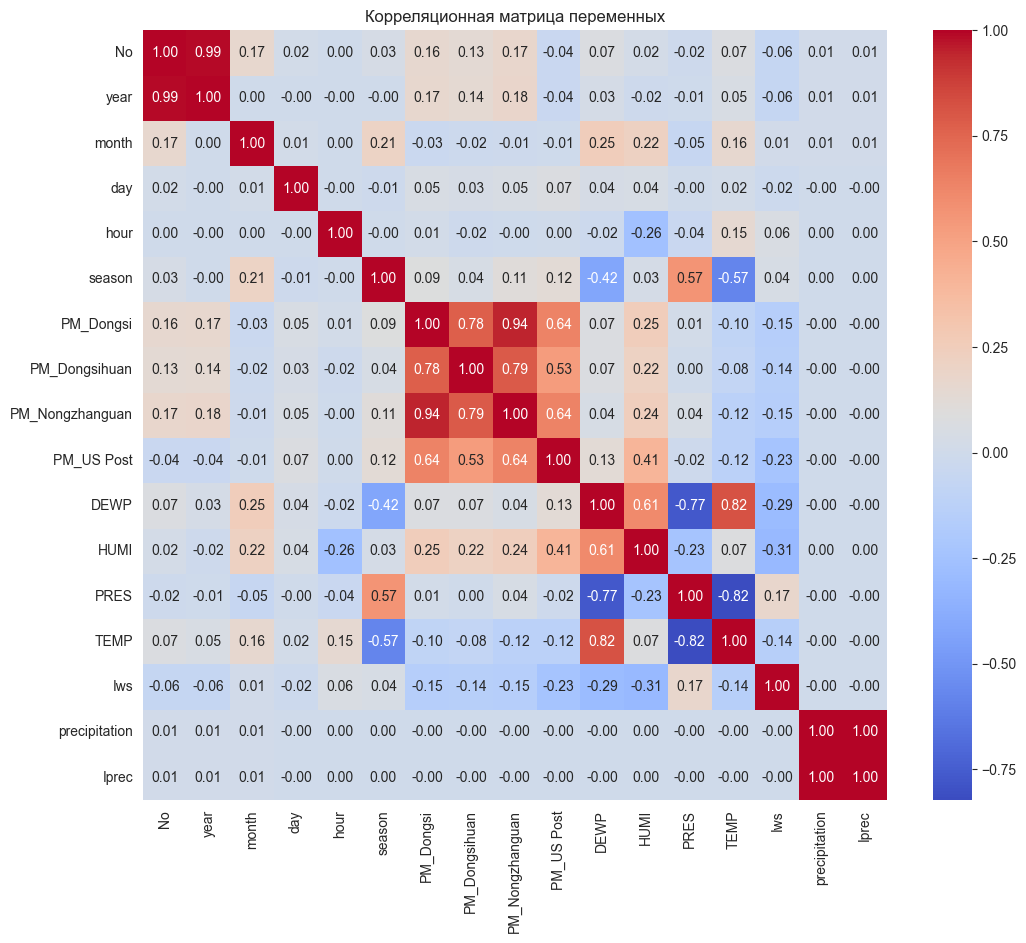

In [171]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_excluding_cbwd, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица переменных")
plt.show()

- Красный цвет обозначает сильную положительную корреляцию (значения близкие к +1).
- Синий цвет обозначает сильную отрицательную корреляцию (значения близкие к -1).
- Цвета ближе к белому указывают на слабую или отсутствующую корреляцию (значения близкие к 0).

**Задание 7.** 
Изучение распределения целевой переменной (загрязнения воздуха) с помощью гистограммы.

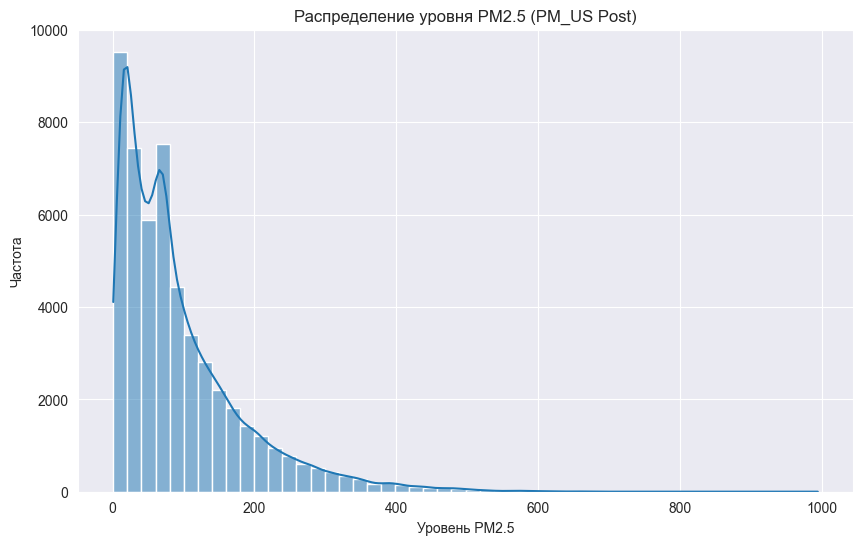

In [172]:
# Выбор одной из переменных, представляющих загрязнение воздуха (PM2.5), например, 'PM_US Post'
target_variable = 'PM_US Post'

# Построение гистограммы для целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(beijing_pm_data_filled[target_variable], bins=50, kde=True)
plt.title(f"Распределение уровня PM2.5 ({target_variable})")
plt.xlabel("Уровень PM2.5")
plt.ylabel("Частота")
plt.show()

- Распределение уровня PM2.5 имеет правостороннюю асимметрию, что означает большее количество наблюдений с низкими значениями PM2.5 и меньшее количество наблюдений с высокими значениями.
- Большая часть значений PM2.5 сконцентрирована в более низком диапазоне, но есть и немало случаев с очень высоким уровнем загрязнения.

**Задание 8.** 
Построение boxplot'ов для выявления выбросов и аномальных значений в числовых переменных.

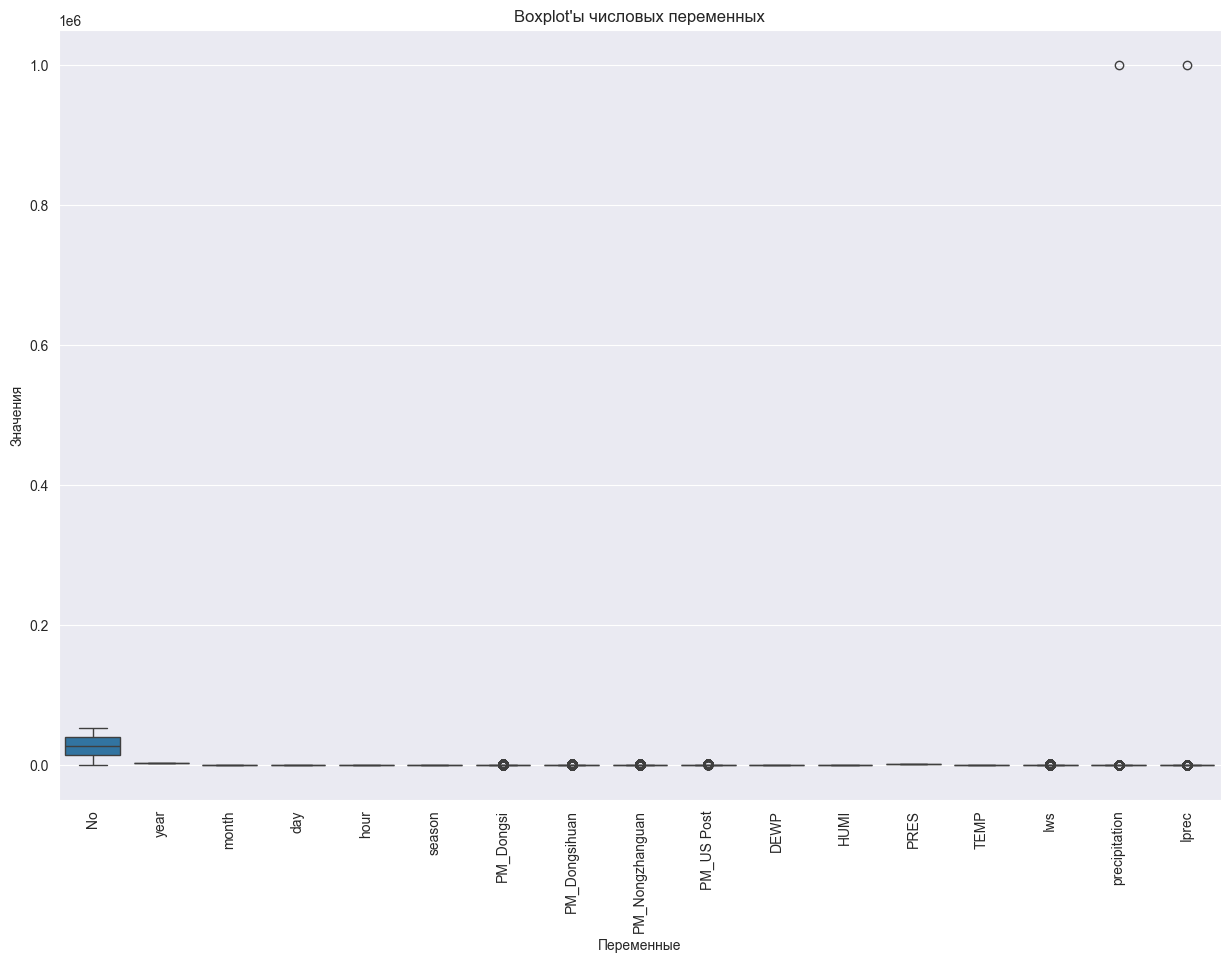

In [173]:
# Построение boxplot'ов для всех числовых переменных
plt.figure(figsize=(15, 10))

# Использование melt для трансформации датафрейма для удобства визуализации
melted_data = numerical_data.melt()

sns.boxplot(x="variable", y="value", data=melted_data)
plt.xticks(rotation=90)
plt.title("Boxplot'ы числовых переменных")
plt.xlabel("Переменные")
plt.ylabel("Значения")
plt.show()

**Задание 9.** 
Преобразование категориальных признаков (если таковые есть) в числовые путем создания dummy-переменных.

In [174]:
# Преобразование категориальных признаков в числовые с помощью создания dummy-переменных
beijing_pm_data_with_dummies = pd.get_dummies(beijing_pm_data_filled, drop_first=True)

beijing_pm_data_with_dummies.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,cbwd_NW,cbwd_SE,cbwd_cv
0,1,2010,1,1,0,4,64.0,68.0,62.0,69.0,-21.0,43.0,1021.0,-11.0,1.79,0.0,0.0,True,False,False
1,2,2010,1,1,1,4,64.0,68.0,62.0,69.0,-21.0,47.0,1020.0,-12.0,4.92,0.0,0.0,True,False,False
2,3,2010,1,1,2,4,64.0,68.0,62.0,69.0,-21.0,43.0,1019.0,-11.0,6.71,0.0,0.0,True,False,False
3,4,2010,1,1,3,4,64.0,68.0,62.0,69.0,-21.0,55.0,1019.0,-14.0,9.84,0.0,0.0,True,False,False
4,5,2010,1,1,4,4,64.0,68.0,62.0,69.0,-20.0,51.0,1018.0,-12.0,12.97,0.0,0.0,True,False,False


Для каждого уникального значения в столбце cbwd была создана отдельная dummy-переменная (например, cbwd_NW, cbwd_SE, cbwd_cv). При этом использовался параметр drop_first=True, чтобы избежать мультиколлинеарности, удалив одну из dummy-переменных для каждой категории.

**Задание 10.** 
Разделение датасета на тренировочную и тестовую выборки для последующего обучения и оценки модели регрессии.

In [175]:
# Выбор целевой переменной для модели регрессии
target = 'PM_US Post'

# Определение признаков (исключая целевую переменную)
features = beijing_pm_data_with_dummies.drop(columns=[target])

# Разделение датасета на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, beijing_pm_data_with_dummies[target], test_size=0.2, random_state=42)

# Вывод размеров полученных выборок
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((42067, 19), (10517, 19), (42067,), (10517,))

**Задание 11.**
Применение метода масштабирования (например, стандартизации) числовых признаков для улучшения работы модели.

In [176]:
# Инициализация стандартизатора
scaler = StandardScaler()

# Масштабирование тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train)

# Масштабирование тестовой выборки (используя параметры из тренировочной выборки)
X_test_scaled = scaler.transform(X_test)

# Проверка масштабированных данных
X_train_scaled[:5], X_test_scaled[:5]

(array([[-0.05783128, -0.29314814,  1.29540844,  1.05273696, -0.94215466,
          0.45506874, -0.19429993, -0.17021791, -0.20355694, -0.42403935,
          0.98275906,  0.14744931, -1.12111788, -0.45511782, -0.00488905,
         -0.00494289, -0.68343119, -0.72708523,  1.8945873 ],
        [-0.14450328, -0.29314814,  1.0056734 , -1.67054758, -0.21807306,
          0.45506874, -0.19429993, -0.17021791, -0.20355694,  0.27968453,
         -0.59863436,  0.14744931,  0.614761  , -0.43690019, -0.00488905,
         -0.00494289, -0.68343119, -0.72708523, -0.52781943],
        [-0.67402636, -0.8792633 ,  1.29540844, -1.67054758,  0.65082486,
          0.45506874, -0.19429993, -0.17021791, -0.20355694,  0.70191886,
          1.0599002 ,  0.63538097,  0.20145651, -0.40977617, -0.00488905,
         -0.00494289,  1.4632051 , -0.72708523, -0.52781943],
        [-0.7481095 , -0.8792633 ,  0.71593835, -0.08196493,  1.23009014,
          0.45506874, -0.19429993, -0.17021791, -0.20355694,  1.26489796,


**Задание 12.**
Выбор модели регрессии (например, линейная регрессия или случайный лес) и обучение модели на тренировочных данных.

In [177]:
model = LinearRegression()

# Обучение модели на тренировочных данных
model.fit(X_train_scaled, y_train)

# Предсказание на тренировочных данных
y_train_pred = model.predict(X_train_scaled)

# Вычисление метрик для оценки качества модели на тренировочных данных
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_train, r2_train

(3680.7533541966395, 0.5486062953206499)

Среднеквадратическая ошибка (MSE): примерно 3680.75
Коэффициент детерминации R*R: примерно 0.549
Среднеквадратическая ошибка (MSE) является мерой среднего квадрата ошибок, т.е. среднего квадрата разностей между фактическими и предсказанными значениями. Низкое значение MSE указывает на лучшее качество модели.

Коэффициент детерминации R*R является мерой того, насколько хорошо будущие выборки будут предсказаны моделью. Значение R*R близкое к 1 указывает на лучшее качество модели.
Модель демонстрирует умеренное качество предсказаний на тренировочных данных.

**Задание 13.**
Оценка модели на тестовых данных с помощью метрик регрессии, таких как коэффициент детерминации (R^2) или среднеквадратичная ошибка (MSE).

In [178]:
# Предсказание на тестовых данных
y_test_pred = model.predict(X_test_scaled)

# Вычисление метрик для оценки качества модели на тестовых данных
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_test, r2_test

(3440.9333644192825, 0.5569048844027611)

- Среднеквадратическая ошибка (MSE): примерно 3440.93
- Коэффициент детерминации (R²): примерно 0.557
Эти результаты говорят о том, что модель имеет схожее качество предсказаний на тестовых данных по сравнению с тренировочными данными. Значение R² близко к 0.557 указывает на то, что модель объясняет примерно 55.7% изменчивости целевой переменной.

**Задание 14.** 
Интерпретация полученных результатов и анализ значимости признаков с помощью коэффициентов модели.

In [179]:
# Получение коэффициентов модели
coefficients = model.coef_

# Сопоставление коэффициентов с именами признаков
feature_names = features.columns
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=["Coefficient"]).sort_values(by="Coefficient", ascending=False)

feature_importance

,Coefficient
precipitation,7165.958719
year,1272.547687
month,213.848397
HUMI,42.198772
PM_Nongzhanguan,26.171943
PM_Dongsi,21.345574
day,21.265120
TEMP,11.087625
cbwd_SE,9.353359
season,7.279428


Наиболее значимые положительные коэффициенты:

- precipitation (осадки): Очень высокий положительный коэффициент, что указывает на сильное положительное влияние этого признака на уровень загрязнения воздуха.
- year (год): Указывает на тенденцию увеличения уровня загрязнения с течением времени.
- month (месяц): Показывает, что определенные месяцы имеют тенденцию к более высоким уровням загрязнения.
- 
Наиболее значимые отрицательные коэффициенты:

- Iprec (интенсивность осадков): Сильный отрицательный коэффициент, указывающий на то, что увеличение интенсивности осадков может уменьшать уровень загрязнения.
- No (номер записи): Отрицательный коэффициент указывает на общее снижение уровня загрязнения со временем, что может быть связано с улучшением мер по контролю за качеством воздуха или другими факторами.
- 
Другие заметные коэффициенты:

- Погодные условия, такие как HUMI (влажность), TEMP (температура) и PRES (давление), также влияют на уровень загрязнения, хотя их вклад меньше по сравнению с осадками.
- Направления ветра (например, cbwd_SE, cbwd_cv, cbwd_NW) также имеют влияние, но менее значительное.

**Задание 15.** 
Предсказание потребления загрязнения воздуха для новых наблюдений на основе обученной модели регрессии.

In [180]:
# Взглянем на первые несколько строк исходного датасета
beijing_pm_data_filled.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,64.0,68.0,62.0,69.0,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,64.0,68.0,62.0,69.0,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,64.0,68.0,62.0,69.0,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,64.0,68.0,62.0,69.0,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,64.0,68.0,62.0,69.0,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [181]:
# Создание примерных новых наблюдений
new_observations = pd.DataFrame({
    'No': [52585, 52586],
    'year': [2016, 2016],
    'month': [1, 1],
    'day': [1, 1],
    'hour': [0, 1],
    'season': [4, 4],
    'PM_Dongsi': [80, 60],
    'PM_Dongsihuan': [90, 70],
    'PM_Nongzhanguan': [85, 65],
    'DEWP': [-5, -4],
    'HUMI': [30, 35],
    'PRES': [1020, 1020],
    'TEMP': [0, 1],
    'cbwd': ['NW', 'SE'],
    'Iws': [5, 10],
    'precipitation': [0, 0],
    'Iprec': [0, 0]
})

# Преобразование категориальных признаков в dummy-переменные
new_observations_with_dummies = pd.get_dummies(new_observations, columns=['cbwd'], drop_first=True)

# Выравнивание столбцов новых наблюдений с тренировочными данными
new_observations_aligned = new_observations_with_dummies.reindex(columns = features.columns, fill_value=0)

# Масштабирование признаков новых наблюдений
new_observations_scaled = scaler.transform(new_observations_aligned)

# Предсказание модели для новых наблюдений
predicted_pm_us_post = model.predict(new_observations_scaled)
predicted_pm_us_post

array([31.28562648, 40.97669139])

**Задание 16.** 
Визуализация связи между переменными загрязнения воздуха и другими факторами с использованием scatter plots.

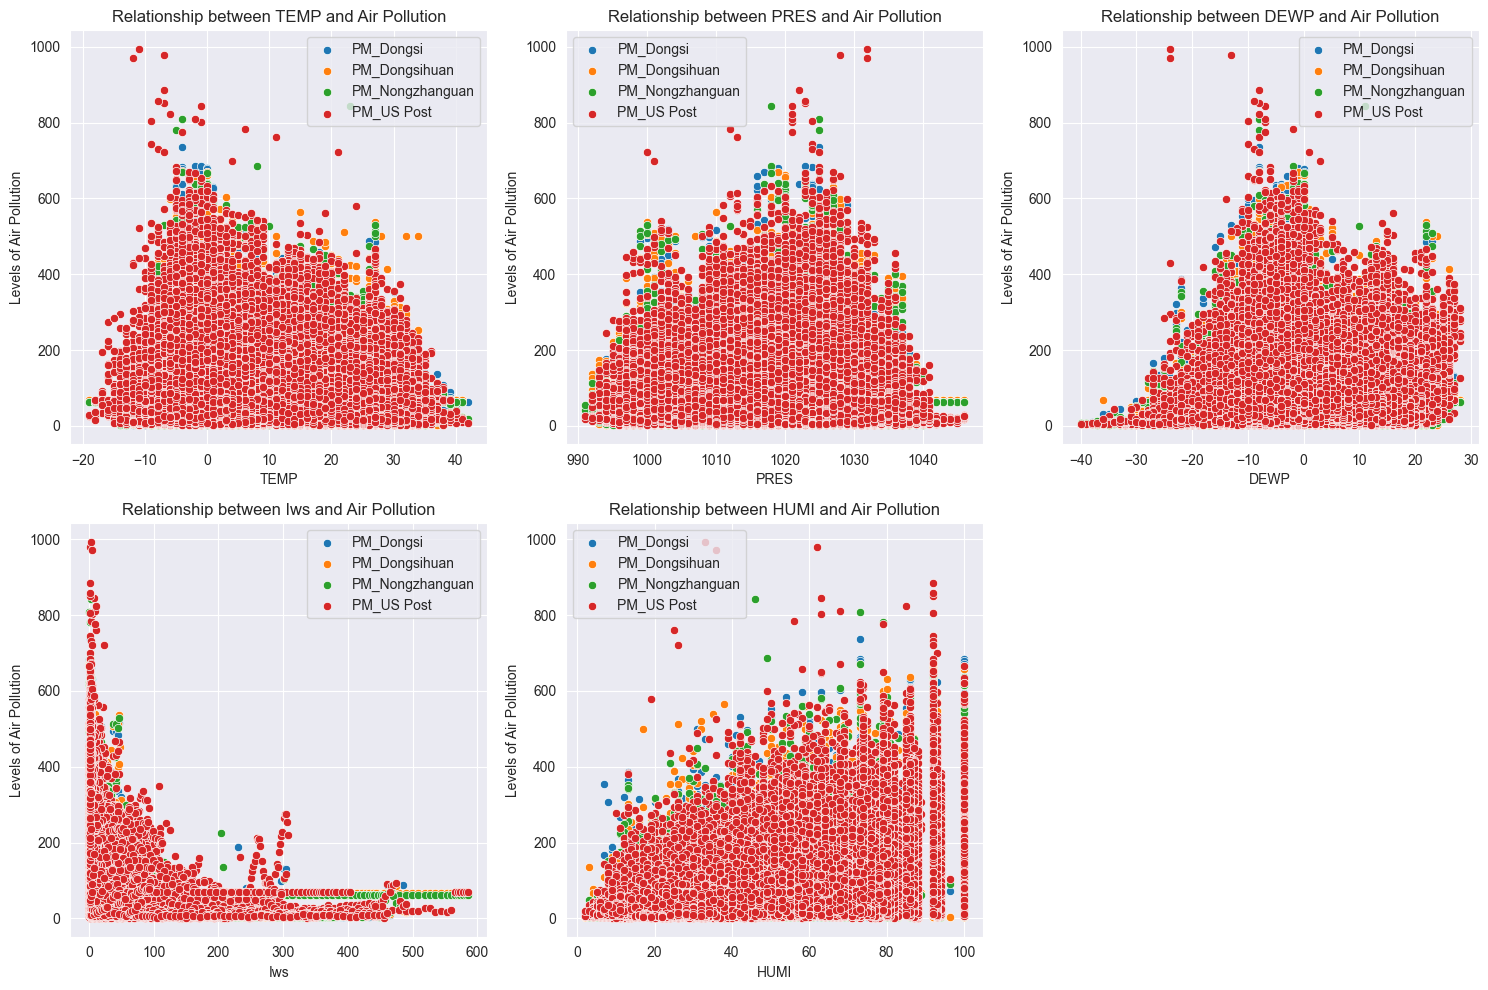

In [182]:
# Выбор переменных загрязнения воздуха и нескольких других факторов для визуализации
air_pollution_variables = ['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post']
other_factors = ['TEMP', 'PRES', 'DEWP', 'Iws', 'HUMI']

# Создание scatter plots
plt.figure(figsize=(15, 10))
for i, factor in enumerate(other_factors, 1):
    plt.subplot(2, 3, i)
    for pollution_var in air_pollution_variables:
        sns.scatterplot(data=beijing_pm_data_filled, x=factor, y=pollution_var, label=pollution_var)
    plt.title(f'Relationship between {factor} and Air Pollution')
    plt.xlabel(factor)
    plt.ylabel('Levels of Air Pollution')
    plt.legend()

plt.tight_layout()
plt.show()

**Задание 17.**
Применение преобразований данных (например, логарифмирование) для улучшения линейности связи между переменными.

In [183]:
# Применение логарифмического преобразования к переменным загрязнения воздуха
# Для избежания проблем с логарифмированием нулевых или отрицательных значений, добавим 1 к значениям перед преобразованием
log_transformed = beijing_pm_data_filled[air_pollution_variables].apply(lambda x: np.log(x + 1))

# Добавление логарифмически преобразованных переменных обратно в датасет
beijing_pm_data_transformed = beijing_pm_data_filled.copy()
for var in air_pollution_variables:
    beijing_pm_data_transformed[var + '_log'] = log_transformed[var]

# Проверка результатов преобразования
beijing_pm_data_transformed.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,...,PRES,TEMP,cbwd,Iws,precipitation,Iprec,PM_Dongsi_log,PM_Dongsihuan_log,PM_Nongzhanguan_log,PM_US Post_log
0,1,2010,1,1,0,4,64.0,68.0,62.0,69.0,...,1021.0,-11.0,NW,1.79,0.0,0.0,4.174387,4.234107,4.143135,4.248495
1,2,2010,1,1,1,4,64.0,68.0,62.0,69.0,...,1020.0,-12.0,NW,4.92,0.0,0.0,4.174387,4.234107,4.143135,4.248495
2,3,2010,1,1,2,4,64.0,68.0,62.0,69.0,...,1019.0,-11.0,NW,6.71,0.0,0.0,4.174387,4.234107,4.143135,4.248495
3,4,2010,1,1,3,4,64.0,68.0,62.0,69.0,...,1019.0,-14.0,NW,9.84,0.0,0.0,4.174387,4.234107,4.143135,4.248495
4,5,2010,1,1,4,4,64.0,68.0,62.0,69.0,...,1018.0,-12.0,NW,12.97,0.0,0.0,4.174387,4.234107,4.143135,4.248495


**Задание 18.**
Оценка значимости выбранных признаков с использованием статистических тестов (например, t-тест).

In [184]:
# Определение порогового значения для PM2.5 на основе медианы
pm_median = beijing_pm_data_transformed['PM_US Post'].median()

# Разделение датасета на две группы: выше медианы и ниже медианы уровня PM2.5
high_pollution = beijing_pm_data_transformed[beijing_pm_data_transformed['PM_US Post'] > pm_median]
low_pollution = beijing_pm_data_transformed[beijing_pm_data_transformed['PM_US Post'] <= pm_median]

# Выбор признака для анализа
feature = 'TEMP'

# Проведение t-теста для сравнения средних значений выбранного признака в двух группах
t_stat, p_value = ttest_ind(high_pollution[feature], low_pollution[feature])

t_stat, p_value

(-4.3342770800521215, 1.465110960617386e-05)

Результаты t-теста для сравнения средних значений температуры (TEMP) в группах с высоким и низким уровнем загрязнения воздуха (PM2.5) следующие:

- Значение t-статистики: -4.33
- p-значение: примерно 0.00001465


Отрицательное значение t-статистики указывает на то, что средняя температура в группе с высоким уровнем загрязнения ниже, чем в группе с низким уровнем. Низкое p-значение (меньше 0.05) позволяет отклонить нулевую гипотезу о том, что средние значения температур в двух группах равны. Это означает, что различия в средних температурах между группами статистически значимы.

Таким образом, температура является значимым фактором в контексте уровней загрязнения воздуха и может быть важным признаком для включения в модели прогнозирования качества воздуха.

**Задание 19.** 
Создание новых признаков на основе существующих (например, комбинация двух переменных).

In [185]:
# Создание новых признаков путем комбинации существующих
# Например, создадим признак, который является произведением температуры и влажности

beijing_pm_data_transformed['TEMP_HUMI'] = beijing_pm_data_transformed['TEMP'] * beijing_pm_data_transformed['HUMI']

# Аналогично создадим признак, который будет представлять собой соотношение скорости ветра к давлению
beijing_pm_data_transformed['Iws_PRES'] = beijing_pm_data_transformed['Iws'] / (beijing_pm_data_transformed['PRES'] + 1)  # Добавляем 1 для избежания деления на ноль

# Проверим созданные признаки
beijing_pm_data_transformed[['TEMP_HUMI', 'Iws_PRES']].head()

,TEMP_HUMI,Iws_PRES
0,-473.0,0.001751
1,-564.0,0.004819
2,-473.0,0.006578
3,-770.0,0.009647
4,-612.0,0.012728


**Задание 20.** 
Проверка модели на переобучение и выбор оптимального количества признаков с помощью кросс-валидации.

In [186]:
# Преобразование категориальных переменных в числовые с помощью dummy-переменных
beijing_pm_data_dummies = pd.get_dummies(beijing_pm_data_filled, drop_first=True)

# Выборка признаков и целевой переменной, исключая целевую переменную 'PM_US Post'
X = beijing_pm_data_dummies.drop(columns=['PM_US Post'])
y = beijing_pm_data_dummies['PM_US Post']

# Масштабирование признаков
X_scaled = scaler.fit_transform(X)

# Попытка кросс-валидации
try:
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    mean_cv_scores = -cv_scores.mean()
    std_cv_scores = cv_scores.std()
    print(f'Mean CV MSE: {mean_cv_scores}, Std CV MSE: {std_cv_scores}')
except Exception as e:
    cross_val_results = f"Ошибка при кросс-валидации: {e}"

Mean CV MSE: 160912606.63151294, Std CV MSE: 321816084.6084873


кросс-валидации с такими высокими значениями среднеквадратической ошибки (MSE) и большим стандартным отклонением могут указывать на несколько проблем:

- Переобучение (Overfitting): Если MSE на тренировочных данных значительно ниже, чем MSE на валидационных наборах в процессе кросс-валидации, это может быть признаком переобучения. Переобученная модель хорошо работает на данных, на которых она была обучена, но плохо обобщает результаты на новых данных.

- Высокая сложность модели: Если модель слишком сложна (например, слишком много признаков или слишком сложная структура), она может "запоминать" данные, а не "обучаться" на них, что ведет к переобучению.

- Проблемы с данными: Высокие значения MSE также могут быть вызваны некорректными данными или выбросами, особенно если данные плохо предобработаны или имеют аномальные значения.

In [187]:
# Выбор признаков и целевой переменной
X = beijing_pm_data_dummies.drop(columns=['PM_US Post'])
y = beijing_pm_data_dummies['PM_US Post']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучение модели с кросс-валидацией
ridge_model = Ridge(alpha=1.0)  # Вы можете настроить параметр alpha
cv_scores = cross_val_score(ridge_model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Расчет среднего и стандартного отклонения MSE
mean_cv_scores = -cv_scores.mean()
std_cv_scores = cv_scores.std()

print(f'Mean CV MSE: {mean_cv_scores}, Std CV MSE: {std_cv_scores}')

Mean CV MSE: 86346.66291749009, Std CV MSE: 163613.27629922272


In [188]:
X = beijing_pm_data_dummies.drop(columns=['PM_US Post'])
y = beijing_pm_data_dummies['PM_US Post']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Настройка GridSearchCV
ridge_model = Ridge()
param_grid = {'alpha': np.logspace(-3, 3, 14)}  # Диапазон для alpha
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Обучение модели
grid_search.fit(X_scaled, y)

# Лучший параметр alpha и результаты MSE
best_alpha = grid_search.best_params_['alpha']
best_mse = -grid_search.best_score_

print(f'Best alpha: {best_alpha}')
print(f'Best MSE: {best_mse}')

Best alpha: 345.5107294592218
Best MSE: 3955.8429793661553


In [189]:
 # Выбор признаков и целевой переменной
X = beijing_pm_data_dummies.drop(columns=['PM_US Post'])
y = beijing_pm_data_dummies['PM_US Post']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Настройка GridSearchCV для случайного леса
rf_model = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, 30]}
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Обучение модели
grid_search_rf.fit(X_scaled, y)

# Лучшие параметры и результаты MSE
best_params_rf = grid_search_rf.best_params_
best_mse_rf = -grid_search_rf.best_score_

print(f'Best parameters: {best_params_rf}')
print(f'Best MSE: {best_mse_rf}')

KeyboardInterrupt: 